In [1]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(SCRIPT_DIR)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tueplots import bundles, figsizes
import matplotlib.style as style
style.use('tableau-colorblind10')

from bocpd import bocpd
from hazard import ConstantHazard
from models import DSMExponentialGaussianSampling

In [2]:
DATA_PATH = os.path.join(SCRIPT_DIR,'data/synthetic')
RESULT_PATH = os.path.join(SCRIPT_DIR,'notebooks/results/synthetic')

In [3]:
np.random.seed(60)
T = 1000
data  = np.zeros((T, 2))
cps   = [250,750]
lambdas = [1/4, 1, 1/8]
mus = [0, 0, 5]
sigmas = [1, 2, 2]
scale = lambdas[0]
mu = mus[0]
var = sigmas[0]
for t in range(0, 1000):
    if t == cps[0]:
        scale = lambdas[1]
        mu = mus[1]
        var = sigmas[1]
    elif t == cps[1]:
        scale = lambdas[2]
        mu = mus[2]
        var = sigmas[2]
    data[t,0] = np.random.exponential(1/scale)
    data[t,1] = np.random.normal(mu, var)

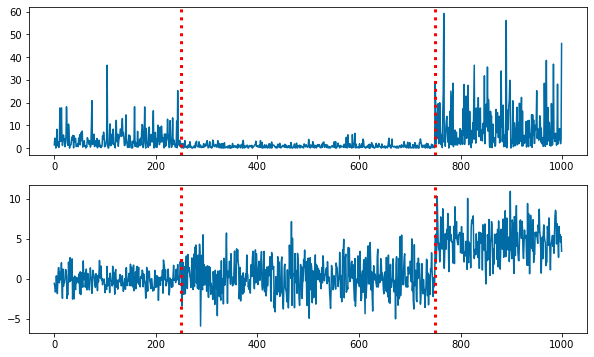

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
ax[0].plot(range(0, 1000),data[:,0])
ax[1].plot(range(0, 1000),data[:,1])
for cp in cps:
    ax[0].axvline(cp, c='red', ls='dotted', lw=3)
    ax[1].axvline(cp, c='red', ls='dotted', lw=3)

In [5]:
def m(x):
    m = np.eye(2)
    m[0,0] = x[0]
    m[1,1] = (1+x[1]**2)**(-1/2)
    return m

def grad_m(x):
    m1 = np.zeros((2,2))
    m1[0,0] = 1
    m2 = np.zeros((2,2))
    m2[1,1] = -x[1]/((1+x[1]**2)**(3/2))
    return np.concatenate((np.asarray([m1]),np.asarray([m2])),axis=0)

def grad_t(x):
    grad_t1 = np.zeros((1,3))
    grad_t1[:,0] = -1
    grad_t2 = np.zeros((1,3))
    grad_t2[:,1] = 1
    grad_t2[:,2] = -x[1]
    return np.concatenate((grad_t1,grad_t2),axis=0)

def grad_b(x):
    return np.asarray([[0],[0]])

def hess_t(x):
    hess_t = np.zeros((2,2,3))
    hess_t[1,1,2]=-1
    return hess_t

beta = 0.006

lambda_mu0 = 1
mean_mu0 = 0
var_mu0 = 2

lambda_Sigma0 = 1
mean_Sigma0 = 4
var_Sigma0 = 5


mu0 = np.asarray([[lambda_mu0],[mean_mu0/var_mu0], [1/var_mu0]])

Sigma0 = np.eye(3)

Sigma0[0,0] = lambda_Sigma0
Sigma0[1,1] = mean_Sigma0/var_Sigma0
Sigma0[2,2] = 1/var_Sigma0

model = DSMExponentialGaussianSampling(data, m ,grad_m, grad_t, hess_t, grad_b, beta, mu0, Sigma0, b = 40)

In [6]:
hazard = ConstantHazard(300)

In [7]:
%%time
R  = bocpd(data, hazard, model, verbose = True)

Processing observation #100
Processing observation #200
Processing observation #300
Processing observation #400
Processing observation #500
Processing observation #600
Processing observation #700
Processing observation #800
Processing observation #900
Processing observation #1000
CPU times: user 3min 9s, sys: 163 ms, total: 3min 10s
Wall time: 3min 12s


/tmp/ipykernel_57626/1646000666.py:20: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=0)


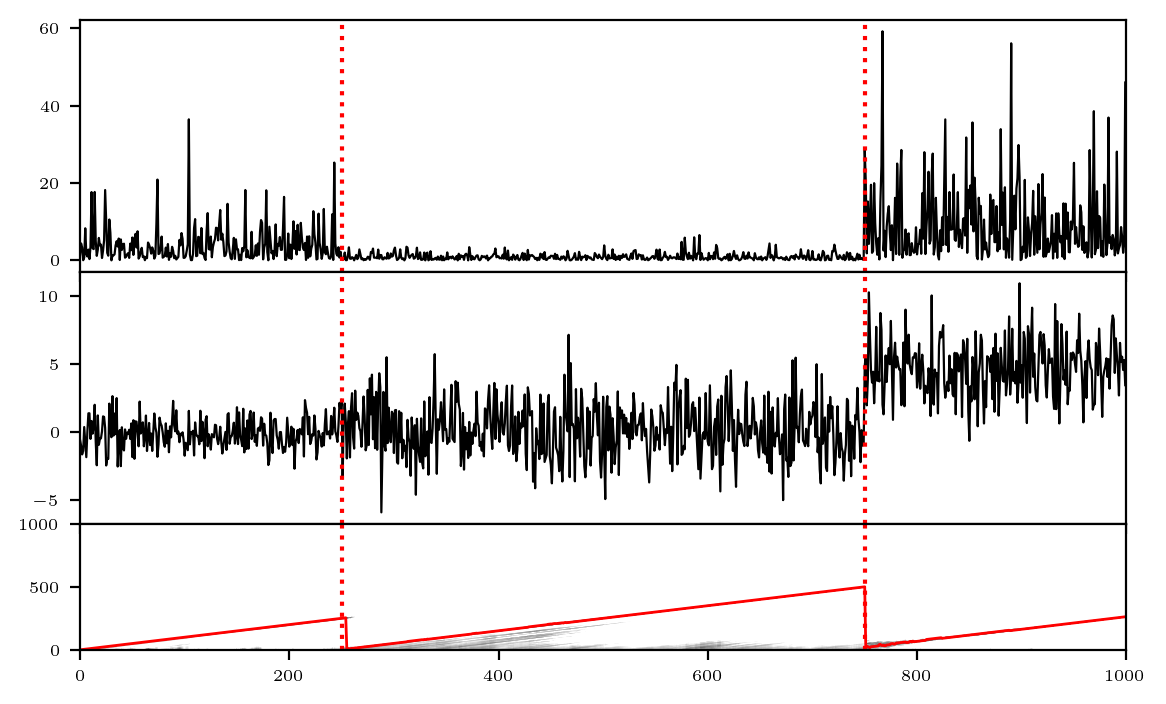

In [8]:
FILE_NAME = 'Synthetic_full.pdf'
with plt.rc_context(bundles.icml2022(column='full')):

    fig, ax = plt.subplots(3, 1, sharex = True, dpi = 200, gridspec_kw={'height_ratios': [2,2,1]})
    ax[0].set_xlim([0, T])
    ax[0].plot(range(0, 1000),data[:,0],color='black',lw=0.8)

    ax[1].set_xlim([0, T])
    ax[1].plot(range(0, 1000),data[:,1],color='black',lw=0.8)

    ax[2].set_xlim([0, T])
    ax[2].imshow(np.rot90(R), aspect='auto', cmap='gray_r', 
                   norm=LogNorm(vmin=0.0001, vmax=1), extent=[0,T,0,T])
    ax[2].plot(np.argmax(R,axis=1), c='r',lw=1)

    for cp in cps:
        ax[0].axvline(cp, c='red', ls='dotted', lw=1.5)
        ax[1].axvline(cp, c='red', ls='dotted', lw=1.5)
        ax[2].axvline(cp, c='red', ls='dotted', lw=1.5)
    fig.subplots_adjust(hspace=0)
    fig.savefig(os.path.join(RESULT_PATH, FILE_NAME), format="pdf", bbox_inches= "tight")

/tmp/ipykernel_57626/3140291652.py:20: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=0)


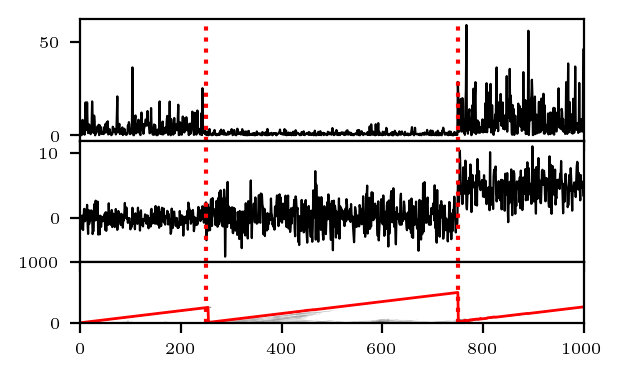

In [9]:
FILE_NAME = 'Synthetic_col.pdf'
with plt.rc_context(bundles.icml2022()):

    fig, ax = plt.subplots(3, 1, sharex = True, dpi = 200, gridspec_kw={'height_ratios': [2,2,1]})
    ax[0].set_xlim([0, T])
    ax[0].plot(range(0, 1000),data[:,0],color='black',lw=0.8)

    ax[1].set_xlim([0, T])
    ax[1].plot(range(0, 1000),data[:,1],color='black',lw=0.8)

    ax[2].set_xlim([0, T])
    ax[2].imshow(np.rot90(R), aspect='auto', cmap='gray_r', 
                   norm=LogNorm(vmin=0.0001, vmax=1), extent=[0,T,0,T])
    ax[2].plot(np.argmax(R,axis=1), c='r',lw=1)

    for cp in cps:
        ax[0].axvline(cp, c='red', ls='dotted', lw=1.5)
        ax[1].axvline(cp, c='red', ls='dotted', lw=1.5)
        ax[2].axvline(cp, c='red', ls='dotted', lw=1.5)
    fig.subplots_adjust(hspace=0)
    fig.savefig(os.path.join(RESULT_PATH, FILE_NAME), format="pdf", bbox_inches= "tight")